# Deep Convolutional Generative Adversarial Networks (DCGAN)

[Paper here](https://arxiv.org/pdf/1511.06434v2)


In [1]:
from rich import print
from tqdm.notebook import tqdm

%load_ext rich


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
import random

random.seed(42)
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# Hyperparameters

LATENT_DIM = 128
GEN_FEATURE_MAP = 64
DISC_FEATURE_MAP = 64

BATCH_SIZE = 128
N_EPOCHS = 10
LEARNING_RATE = 2e-4

## Load the dataset

In [43]:
transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)


In [44]:
train_dataset = CIFAR10(root="./data/", download=True, train=True, transform=transform)
test_dataset = CIFAR10(root="./data/", download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [45]:
def reverse_transform(x):
    x = x * 0.5 + 0.5
    x = transforms.ToPILImage()(x)

    return x


In [46]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [47]:
len(train_loader), len(test_loader)

(391, 79)

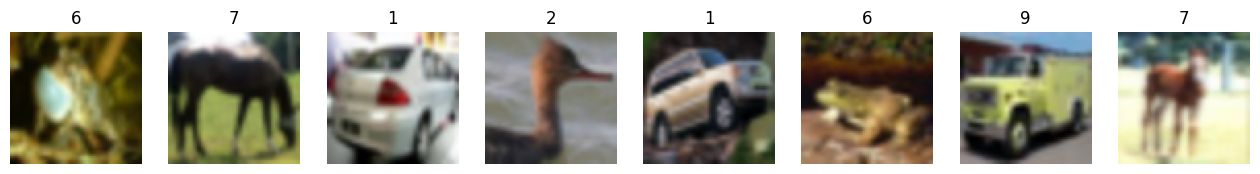

In [48]:
fig, axs = plt.subplots(1, 8, figsize=(16, 2))
indices = torch.randperm(len(train_dataset))[:8]
for i, idx in enumerate(indices):
    img, label = train_dataset[idx]
    img = reverse_transform(img)
    axs[i].imshow(img, cmap="gray")
    axs[i].set_title(label)
    axs[i].axis("off")

plt.show()

## Build the architecture

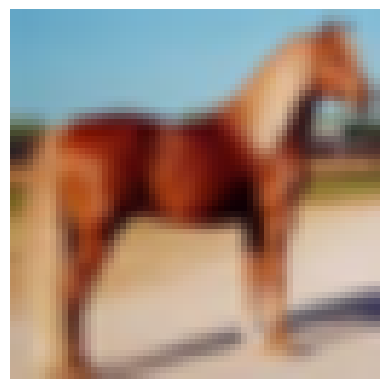

torch.Size([3, 64, 64])

7

In [49]:
sample_image, sample_label = train_loader.dataset[43]
plt.imshow(reverse_transform(sample_image))
plt.axis("off")
plt.show()

print(sample_image.shape)
print(sample_label)

In [50]:
class Generator(nn.Module):
    def __init__(self, latent_dim, feature_size, debug=False):
        super(Generator, self).__init__()

        self.latent_dim = latent_dim
        self.feature_size = feature_size

        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                latent_dim,
                feature_size * 8,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.BatchNorm2d(feature_size * 8),
            nn.ReLU(True),
        )

        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                feature_size * 8,
                feature_size * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),
        )

        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                feature_size * 4,
                feature_size * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),
        )

        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                feature_size * 2,
                feature_size,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),
        )

        self.output = nn.Sequential(
            nn.ConvTranspose2d(
                feature_size,
                3,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.Tanh(),
        )

        self.debug = debug

        self.apply(self._init_weights)

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def _init_weights(self, m):
        if isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

        if isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        self._debug_print(x, "[GENERATOR] Input")
        x = self.conv1(x)
        self._debug_print(x, "[GENERATOR] Conv1")
        x = self.conv2(x)
        self._debug_print(x, "[GENERATOR] Conv2")
        x = self.conv3(x)
        self._debug_print(x, "[GENERATOR] Conv3")
        x = self.conv4(x)
        self._debug_print(x, "[GENERATOR] Conv4")
        x = self.output(x)
        self._debug_print(x, "[GENERATOR] Output")

        return x


[GENERATOR] Input: torch.Size([8, 128, 1, 1])

[GENERATOR] Conv1: torch.Size([8, 512, 4, 4])

[GENERATOR] Conv2: torch.Size([8, 256, 8, 8])

[GENERATOR] Conv3: torch.Size([8, 128, 16, 16])

[GENERATOR] Conv4: torch.Size([8, 64, 32, 32])

[GENERATOR] Output: torch.Size([8, 3, 64, 64])

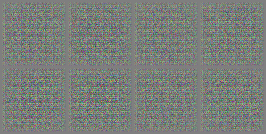

In [51]:
g = Generator(128, 64, debug=True)

reverse_transform(make_grid(g(torch.randn(8, 128, 1, 1)), nrow=4))


In [52]:
class Discriminator(nn.Module):
    def __init__(self, feature_size, debug=False):
        super(Discriminator, self).__init__()

        self.feature_size = feature_size

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=feature_size,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=feature_size,
                out_channels=feature_size * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=feature_size * 2,
                out_channels=feature_size * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=feature_size * 4,
                out_channels=feature_size * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.output = nn.Sequential(
            nn.Conv2d(
                in_channels=feature_size * 8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.Sigmoid(),
        )

        self.debug = debug

        self.apply(self._init_weights)

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def _init_weights(self, m):
        if isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

        if isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        self._debug_print(x, "[DISCRIMINATOR] Input")
        x = self.conv1(x)
        self._debug_print(x, "[DISCRIMINATOR] Conv1")
        x = self.conv2(x)
        self._debug_print(x, "[DISCRIMINATOR] Conv2")
        x = self.conv3(x)
        self._debug_print(x, "[DISCRIMINATOR] Conv3")
        x = self.conv4(x)
        self._debug_print(x, "[DISCRIMINATOR] Conv4")
        x = self.output(x)
        self._debug_print(x, "[DISCRIMINATOR] Output")
        return x


In [53]:
Discriminator(64, debug=True)(train_dataset[0][0].unsqueeze(0))

[DISCRIMINATOR] Input: torch.Size([1, 3, 64, 64])

[DISCRIMINATOR] Conv1: torch.Size([1, 64, 32, 32])

[DISCRIMINATOR] Conv2: torch.Size([1, 128, 16, 16])

[DISCRIMINATOR] Conv3: torch.Size([1, 256, 8, 8])

[DISCRIMINATOR] Conv4: torch.Size([1, 512, 4, 4])

[DISCRIMINATOR] Output: torch.Size([1, 1, 1, 1])

tensor([[[[0.5507]]]], grad_fn=<SigmoidBackward0>)

In [58]:
g = Generator(latent_dim=LATENT_DIM, feature_size=GEN_FEATURE_MAP).to(device)
d = Discriminator(feature_size=DISC_FEATURE_MAP).to(device)

loss_fn = nn.BCELoss()

g_optimizer = torch.optim.Adam(g.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(d.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

print(
    f"Total number of parameters in both models: {sum(p.numel() for p in g.parameters()) + sum(p.numel() for p in d.parameters())}"
)

val_noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1, device=device)

real_label = 1.0
fake_label = 0.0

Total number of parameters in both models: 6571648

In [59]:
val_imgs = []
g_losses = []
d_losses = []
steps = 0

for epoch in tqdm(range(N_EPOCHS), desc="Epochs"):
    # -------------------
    # Training loop
    # -------------------
    for idx, (imgs, _) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch}")):
        batch_size = imgs.size(0)
        imgs = imgs.to(device)

        ## Train Discriminator
        d_optimizer.zero_grad()
        ### Train on batch of real images
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)

        real_output = d(imgs).view(-1)

        real_loss = loss_fn(real_output, label)
        real_loss.backward()

        ### Train on batch of fake images
        noise = torch.randn(batch_size, LATENT_DIM, 1, 1, device=device)
        fake_imgs = g(noise)
        label.fill_(fake_label)

        disc_fake_output = d(fake_imgs.detach()).view(-1)

        fake_loss = loss_fn(disc_fake_output, label)
        fake_loss.backward()

        d_loss = real_loss + fake_loss
        d_optimizer.step()

        # -------------------------------

        ## Train Generator
        g_optimizer.zero_grad()
        label.fill_(real_label)

        gen_fake_output = d(fake_imgs).view(-1)

        g_loss = loss_fn(gen_fake_output, label)
        g_loss.backward()

        g_optimizer.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        # -------------------------------
        ## Training statistics
        d_x = real_output.mean().item()
        d_g_z_1 = disc_fake_output.mean().item()
        d_g_z_2 = gen_fake_output.mean().item()

        if idx % 50 == 0:
            print(
                f"Epoch: {epoch} | Batch: {idx} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f} | D(x): {d_x:.4f} | D(G(z)): {d_g_z_1:.4f} / {d_g_z_2:.4f}"
            )

        # -------------------------------
        # Check generator output on fixed noise
        if (steps % 500 == 0) or (
            (epoch == N_EPOCHS - 1) and (idx == len(train_loader) - 1)
        ):
            with torch.no_grad():
                fake = g(val_noise).detach().cpu()
                val_imgs.append(make_grid(fake, padding=2, normalize=True))

        steps += 1

    print(
        f"Epoch: {epoch} | G Loss: {np.mean(g_losses):.4f} | D Loss: {np.mean(d_losses):.4f}"
    )

    break

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 0 | Batch: 0 | D Loss: 1.3638 | G Loss: 3.4109 | D(x): 0.5040 | D(G(z)): 0.4788 / 0.0353

Epoch: 0 | Batch: 50 | D Loss: 0.5960 | G Loss: 13.1758 | D(x): 0.6905 | D(G(z)): 0.0000 / 0.0000

Epoch: 0 | Batch: 100 | D Loss: 0.6445 | G Loss: 5.7139 | D(x): 0.9164 | D(G(z)): 0.4008 / 0.0040

Epoch: 0 | Batch: 150 | D Loss: 0.0914 | G Loss: 4.2906 | D(x): 0.9377 | D(G(z)): 0.0228 / 0.0189

Epoch: 0 | Batch: 200 | D Loss: 0.1506 | G Loss: 7.6917 | D(x): 0.9594 | D(G(z)): 0.0909 / 0.0006

Epoch: 0 | Batch: 250 | D Loss: 0.1742 | G Loss: 5.6393 | D(x): 0.8878 | D(G(z)): 0.0383 / 0.0072

Epoch: 0 | Batch: 300 | D Loss: 0.1393 | G Loss: 5.2513 | D(x): 0.9295 | D(G(z)): 0.0540 / 0.0073

Epoch: 0 | Batch: 350 | D Loss: 0.3173 | G Loss: 4.8522 | D(x): 0.8871 | D(G(z)): 0.1568 / 0.0093

Epoch: 0 | G Loss: 6.0118 | D Loss: 0.5017

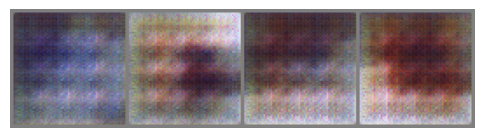

In [65]:
g.eval()
d.eval()

plt.figure(figsize=(6, 6))
plt.imshow(
    reverse_transform(make_grid(g(torch.randn(4, LATENT_DIM, 1, 1).to(device)), nrow=4))
)
plt.axis("off")
plt.show()